<a href="https://colab.research.google.com/github/SondreOlimb/TTT4185---Machine-Learning-for-Signal-Processing/blob/main/TTT4185_assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TTT4185 Machine learning for Speech technology

## Computer assignment 2: Classification using the Bayes Decision Rule and Support Vector Machines

This assignment assumes that the student has knowledge about the Bayes Decision Rule, maximum likelihood estimation and support vector machines.

In this assignment we will use `scikit-learn` (http://scikit-learn.org/stable/), which is a powerful and very popular Python toolkit for data analysis and machine learning, and `pandas` (https://pandas.pydata.org), which implements the all-powerful `DataFrame`.

We will also be using a small database of phonemes, where each phoneme is represented by the four first formant positions ("F1"-"F4") and their corresponding bandwidths ("B1"-"B4"). All numbers are in kHz. In addition, the speaker ID and the gender of the speaker are given for each phoneme.

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
!pip install plotly==5.3.0
!pip install jupyter_contrib_nbextensions
import plotly.express as px
import plotly.graph_objects as go

# Problem 1

In this problem we will use the Bayes decision rule to classify vowels based on their formants. The formants have been extracted from the open database `VTR Formants database` (http://www.seas.ucla.edu/spapl/VTRFormants.html) created by Microsoft and UCLA.



##(a) 
Download the files `Train.csv` and `Test.csv` from Blackboard, and load them into a `pandas` dataframe using the command `pd.read_csv`. Using the training data, create a single scatter plot of "F1" vs "F2" for the three vowels
- "ae" as in "bat"
- "ey" as in "bait"
- "ux" as in "boot"

Just eyeing the plots, discuss which classes will be hardest to classify correctly.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib notebook

# Load data
train = pd.read_csv("/content/drive/My Drive/ML/Train.csv")
test = pd.read_csv("/content/drive/My Drive/ML/Test.csv")


# Extract vowels
aes = train[train["Phoneme"] == 'ae']
eys = train[train["Phoneme"] == 'ey']
uxs = train[train["Phoneme"] == 'ux']

# Plotting here
f1 = train["F1"]
f2 = train["F2"]

In [21]:
fig = go.Figure()
fig.add_trace( go.Scatter(x= aes["F1"],y=aes["F2"], mode='markers', name="ae"))
fig.add_trace( go.Scatter(x= eys["F1"],y=eys["F2"], mode='markers', name="ey"))
fig.add_trace( go.Scatter(x= uxs["F1"],y=uxs["F2"], mode='markers', name="ux"))
fig.show()

**Solution**

*   Firstly we can se in the scatterplot above that it will be easiest to separate *ae* and *ux*  
*   We can also see that the overlap betwen ae and ey is larrger making it harder to separate
* lastly we have ux and ey with e large overlap making it more dificult to seperate 

<hr>



##(b) 
Use the Bayes Decision Rule to create a classifier for the phonemes 'ae', 'ey' and 'ux' under the following constraints:
- The feature vector $x$ contains the first two formants, "F1" and "F2".
- The distribution of $x$ given a phoneme $c$, $P(x|c)$, is Gaussian.
- Use the maximum likelihood estimator to estimate the model parameters.

**Theory**

Bayes decision theory is( in our case) given by:

$
P(c_k|x) = \dfrac{P(x)|c_k)P(c)}{P(x)} = \dfrac{P(x)|c_k)P(c)}{\sum P(x∣c)P(c)}
$

We want to creat a Gaussian Naive Bayes classifier i.e we want to find 
$P(c_k|x)$. Where c is the class we want to calssify, k is the number of classes
and x is the independed feature vector. 





For better understaning we can wite this equation as:

$
Posterior = \dfrac{Liklihood \cdot Prior}{Evidence}
\tag{2}
$




The Maximum Liklihood Estimator then becomes:

$
MLE =argmax(P(c_k|x))= argmax(\dfrac{P(x)|c_k)P(c)}{\sum P(x∣c)P(c)})
\tag{3}
$

In the equation (3) we alrady know $P(x|c)$ and $P(c)$



 P(x|c) is given in the task to be a gaussia, we can therfor use the
 multivariate normal distribution for P(x|c). This distibution in given by the
 equation below and is implimented in the scipy library *scipy.stats.multivariate_normal*.

$
\begin{equation}
f(x|\mu,\Sigma) = \dfrac{-\dfrac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)}{(2\pi)^{D/2}|\Sigma|^{1/2}}
\tag{4}
\end{equation}
$

Where $\mu$ is the mean vector and $\Sigma$ is the covarianse matrix, $D$ is the dimension of the space where $x$ takes values.

We need to calculate the mean and covariance matrix.


$P(c)$ is the Prior and is given by

$
P(c) = \dfrac{\text{Nr. of phonemes c}}{\text{Total nr. of phonemes}}
\tag{5} 
$







In [22]:
"""
We pre process the data too a format we can handel 
"""
data = {"aes": aes, "eys":eys, "uxs":uxs}

###Priors
We define a function for calculation of priors, covariance matrix and the mean.

In [23]:


def Prior(data,test = False):
  """
  Calculates the prior propobility P(c) of eache Ponems and returs them.


  """
  total_nr_phonemes = 0
  priors ={}
  for i in data:
    total_nr_phonemes += len(data[i])
    priors[i] = len(data[i])
  
  for i in priors:
    priors[i] = priors[i]/total_nr_phonemes

  #created a test to verify
  if test:
    test_prob = 0
    for i in priors:
      test_prob += priors[i]
    if round(test_prob) == 1:
      return priors
    else:
      print("Error: total probability wasnt 1, it was: ", test_prob)
      return 
  else:
    return priors
  





###Covarance matrix and mean vector

We dafine functions for calculating the covariance matrix and mean.

In [24]:
from scipy.stats import multivariate_normal


def cov_mat(data,nr_of_formats = 2,diagonal = False):
  '''
  Calculates the covariance matrix  for each phonem and returns them in a
  dictionary with the phomnem as key.
  '''
  covs = {}
  for phonem in data:
   
    format_arr =[]
    for j in range(1,nr_of_formats +1):
      if j <=4:
        format = "F"+str(j)
      else:
        format = "B"+str(j-4)
      format_arr.append(data[phonem][format])
    
    format_cov = np.cov(np.array(format_arr), bias=False) #bias=false calsulates teh sample covariance matrix
    if diagonal:
      format_cov = np.diag(format_cov)
    
    covs[phonem] = format_cov
  return covs

def mean(data,nr_of_formats = 2):
  '''
  Calculates the mean for eace format in each phonem and returns a dictionary
  with the means as an array 2x1 and the phonem as te key 
  '''
  means = {}
  

  for phonem in data:
     
    format_mean =[]
    for j in range(1,nr_of_formats +1):
      if j <=4:
        format = "F"+str(j)
      else:
        format = "B"+str(j-4)

      format_mean.append(np.mean(data[phonem][format]))
    means[phonem] =format_mean
  return means



def random_vars(data,nr_of_formats = 2, diagonal = False):
  """
  calculate P(x|c)
  """
  covs = cov_mat(data=data, nr_of_formats= nr_of_formats, diagonal = diagonal)
  
  
  means = mean(data=data, nr_of_formats= nr_of_formats)
  
  rnd_var = {}

  for phonem in data:
    rv = multivariate_normal(mean = means[phonem],cov = covs[phonem])
    rnd_var[phonem] = rv
  return rnd_var




In [25]:
"""
Pre processing the Test data
"""

aes_test = test[test["Phoneme"] == 'ae']
eys_test = test[test["Phoneme"] == 'ey']
uxs_test = test[test["Phoneme"] == 'ux']


data_test = {"aes": aes_test, "eys":eys_test, "uxs":uxs_test}

###Classifier
We define a fuction that immplements the Gaussian Naive Bayes classifier.

In [26]:

def classifier(train_data, test_data, nr_of_formats = 2):

  """
  Firstly it calls on the fuctions to train the classsifier, before it
  classifies the the test data and calculates the error rate.
  
  """

  true_lable =[]
  predicted_lable =[]
  rnd_vars = random_vars(train_data,nr_of_formats=nr_of_formats) #Calculates the liklihood P(x|c)
  priors = Prior(data=train_data, test = True) # Calls on the function to calculate the priors P(c)
  
  

  keys = list(test_data.keys())
  
  
  
  formats = []
  for i in range(1,nr_of_formats+1):
    #Findes out which features to calculate for.
    if i <= 4:
      f = "F"+str(i)
      formats.append(f)
    else:
      f = "B"+str(i-4)
      formats.append(f)
  

  
  f1_f2 =[]
  
  for phonem in test_data:
    
    temp = test_data[phonem][formats]#Exctracts the televant data from the test data
    true_lable += [phonem]*len(test_data[phonem]) #Makes an array of true labels for verification
    
    f1_f2.append(temp)
  f1_f2 = pd.concat(f1_f2)#turnes the arays into dataframes
  


  
  

  pred_arr = []

  for phonem in rnd_vars:
    
    pred = priors[phonem]*rnd_vars[phonem].pdf(np.array(f1_f2)) # calculates P(x|c)P(c) with the testdata
    pred_arr.append(pred)


  Px = np.sum(pred_arr,axis =0)#calculates sum(P(x|c)P(c))
  
  P = (np.array(pred_arr)/Px) #finally  P(x|c)P(c)/sum(P(x|c)P(c))
  

  #P is now an array 3x271(in our case)

  pred = np.argmax(P,axis=0) #Findes tha max for each row in the P 2-dim array, and saves it in the array pred

 
  for i in pred:
    predicted_lable.append(keys[i]) #stores the predicted phonem
  
  

  error = 0
  
  for n,i in enumerate(predicted_lable): #calculates the error rate
    if i != true_lable[n]:
      error +=1
  
  error_rate = error/len(predicted_lable)
  

  print("Error rate was:", round(error_rate*100,2),"%" )
  
  return true_lable,predicted_lable,error_rate




In [27]:
true_lable,predicted_lable,error_rate = classifier(data,data_test,2)

Error rate was: 26.2 %




---



##(c)
To visualize the classes models and the classifier created in (b), plot the contours for each Gaussian distribution in the model, that is the class conditional likelihoods $P(x|c)$, by using the following function.

In [28]:
import scipy.stats
%matplotlib notebook

def plotGaussian(mean, cov, color, ax):
    """ 
        Creates a contour plot for a bi-variate normal distribution
        
        mean: numpy array 2x1 with mean vector
        cov: numpy array 2x2 with covarince matrix
        color: name of color for the plot (see https://matplotlib.org/stable/gallery/color/named_colors.html)
        ax: axis handle where the plot is drawn (can for example be returned by plt.gca() or plt.subplots())
    """
    xlim = ax.get_xlim()
    
    ylim = ax.get_ylim()
    x, y = np.mgrid[xlim[0]:xlim[1]:(xlim[1]-xlim[0])/500.0, ylim[0]:ylim[1]:(ylim[1]-ylim[0])/500.0]
    xy = np.dstack((x, y))
    mvn = scipy.stats.multivariate_normal(mean, cov)
    lik = mvn.pdf(xy)
    
    ax.contour(x,y,lik,colors=color)
    




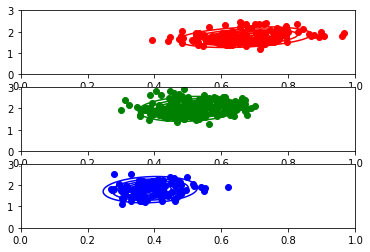

In [29]:
covs = cov_mat(data=data, nr_of_formats= 2)
means = mean(data=data, nr_of_formats= 2)
%matplotlib inline
col =["r","g","b"]

fig , axs = plt.subplots(3,1)

for n,i in enumerate(data):
  axs[n].set_xlim(0,1)
  axs[n].set_ylim(0,3)
  axs[n].scatter(data[i]["F1"],data[i]["F2"],color = col[n])
 
  plotGaussian(mean= means[i], cov = covs[i], color = col[n], ax = axs[n])

  
plt.show()

*Try:* Plot the decision regions for the Bayesian classifier. Tips: Calculate the posterior for each class, use the `numpy.argmax` function to get the decision regions, and `matplotlib.pyplot.contourf` to plot them.



---



##(d)
Test your classifier on the 'ae', 'ey' and 'ux' phonemes from the test set and present your results in a _confusion matrix_, that is, a table where you see how many times 'ae' was correctly classified, how many times it was wrongly classified as 'ey' and so on.

Error rate was: 26.2 %


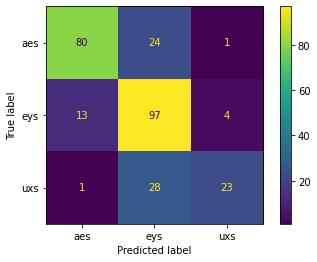

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
true_lable,predicted_lable,error_rate = classifier(data,data_test,2)
cm = confusion_matrix(y_true = true_lable, y_pred =predicted_lable)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= list(data.keys()))

disp.plot()
plt.show()

If we look at the confffusion matrix above we can se that the resutls reflect the expectations that we had in task one. ey is misklassified as the outher two the most, and ae and ux has almsot no miss classifications ass echother.

<hr>

##(e) 
Extend your classifier to include the features "F1"-"F4" and compare the results with those in (d). Finally use all available information "F1"-"F4" and "B1-B4". How does the performance of this classifier compare with the simpler classifiers using fewer features?

Error rate was: 24.35 %


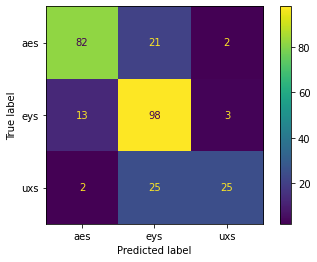

In [31]:
"""
with f1-f4 
"""
true_lable,predicted_lable,error_rate = classifier(data,data_test,4)

cm = confusion_matrix(y_true = true_lable, y_pred =predicted_lable)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= list(data.keys()))

disp.plot()
plt.show()

**Solution**

We can se that with all formats the classifier preforms sligtly better, decresing the error rate from 26% to 24%. so with this classefier we incresed the feature set in avalibol data only gave us a 2 percent points better preformance

Error rate was: 28.78 %


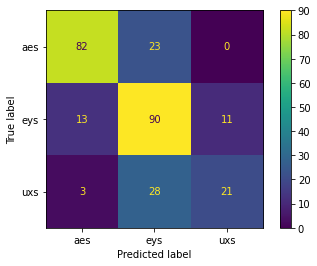

In [32]:
"""
with f1-f4 and b1-b4
"""
true_lable,predicted_lable,error_rate = classifier(data,data_test,8)

cm = confusion_matrix(y_true = true_lable, y_pred =predicted_lable)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= list(data.keys()))

disp.plot()
plt.show()

**Solution**

We can se that we loose 2 percent points in preformance by including all avalobol information.



---



##(f)
 We want to make the model slightly more powerful by modeling the feature vector conditional on both the vowel and gender of speaker, that is $P(x|g,c)$, where $g$ is the gender of the speaker and $c$ is the phoneme label. Show how these models can be used for phoneme classification using marginalization over the gender.

Assume that $P(x|g,c)$ is a multivariate Gaussian and compute the maximum likelihood estimates for the models. Compare the result on the test set with the results in (e).

<font color ="Red"><h1 >Theory</h1>

From the total probabilty theorm we have:

$
P(A)= \sum_n P(A|B_n)P(B_n)
$

I we wiwite this for P(x|g,c) where A=P(x|c) and B = P(g) we get: 

$
P(x|c) = \sum P(x|g,c)P(g)
\tag{6}
$

if we insert equation (6) into equation (3) we get equation (7)


$P(c_k|x)_{mle}= argmax(\dfrac{P(x)|c_k)P(c)}{\sum P(x∣c)P(c)})= argmax(\dfrac{\sum (P(x|g,c)P(g))P(c)}{\sum P(x∣c)P(c)})
\tag{7}
$















In [33]:
"""
We need to preprocess the data, since we now have new keys where we have the phonome and gender
"""
data_gender = {}
for i in data:
  data_gender[i +"_M"] = data[i][data[i]["Gender"] == "M"]
  data_gender[i +"_F"] = data[i][data[i]["Gender"] == "F"]



gender_data ={}
M=[]
F=[]
for i in data:
  M.append( data[i][data[i]["Gender"] == "M"])
  F.append(data[i][data[i]["Gender"] == "F"])

gender_data["M"] = pd.concat(M)
gender_data["F"] = pd.concat(F)

P_M = len(M)/(len(M)+len(F))

P_G ={"M":P_M,"F":1-P_M}


In [34]:
def classifier_g(train_data, test_data, nr_of_formats = 2, diagonal = False):

  """
  Firstly it calls on the fuctions to train the classsifier, before it
  classifies the the test data and calculates the error rate.
  
  """

  true_lable =[]
  
  rnd_vars = random_vars(train_data,nr_of_formats=nr_of_formats,diagonal = diagonal)
  priors = Prior(data=train_data, test = True)
  
  

  keys = list(test_data.keys())
  
  
  
  formats = []
  for i in range(1,nr_of_formats+1):
    if i <= 4:
      f = "F"+str(i)
      formats.append(f)
    else:
      f = "B"+str(i-4)
      formats.append(f)
  

  
  f1_f2 =[]
  
  for phonem in test_data:
    temp = test_data[phonem][formats]
    true_lable += [phonem]*len(test_data[phonem]) 
    
    f1_f2.append(temp)
  f1_f2 = pd.concat(f1_f2)
  

  
  
  

  pred_arr = []
 
  
  for phonem in rnd_vars:
      
      pred = priors[phonem]*rnd_vars[phonem].pdf(np.array(f1_f2))#calculates P(x|g,c)P(g)P(c)
      
      pred_arr.append(pred)

  #Need to find the predicted value
  

  
  P_store = [[],[],[]]
  predicted_lable =[]
  for n,i in enumerate(true_lable):
    #need to take the sum in the numerator
    ae = pred_arr[0][n] + pred_arr[1][n]
    ey = pred_arr[2][n] + pred_arr[3][n]
    ux = pred_arr[4][n] + pred_arr[5][n]

    P_store[0].append(ae)
    P_store[1].append(ey)
    P_store[2].append(ux)
  
  
  Px = np.sum(P_store,axis =0) #calculates sum(P(x|c)P(c)) #Obs this sum makes sence becouse of the total probability thorem

  P = (np.array(P_store)/Px) #sum(P(x|g,c)P(g)P(c))/ sum(P(x|c)P(c))
 
  
  pred = np.argmax(P,axis=0)
  
  


  
  for i in pred:
      predicted_lable.append(keys[i])#finds the coreponding phonems
 
  


  error = 0
  
  for n,i in enumerate(predicted_lable): #Calculates the error rate
    
    
    if i != true_lable[n]:
      error +=1
  
  error_rate = error/len(predicted_lable)
  

  print("Error rate was:", round(error_rate*100,2),"%" )
  
  return true_lable,predicted_lable,error_rate

Error rate was: 23.62 %


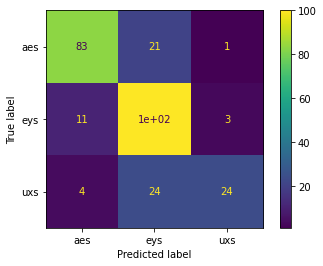

In [35]:
"""
with f1-f4
"""


true_lable,predicted_lable,error_rate = classifier_g(data_gender,data_test,4)


cm = confusion_matrix(y_true = true_lable, y_pred =predicted_lable)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= list(data.keys()))

disp.plot()
plt.show()

As we can se we geain an addisional 24.35-23.62 = 0.7 percent points. so only a sligth improvment

Error rate was: 27.31 %


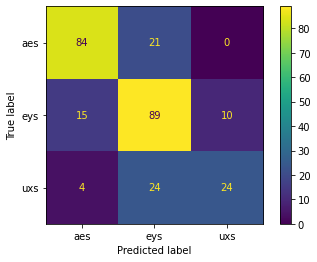

In [36]:
"""
with f1-f4
"""


true_lable,predicted_lable,error_rate = classifier_g(data_gender,data_test,8)


cm = confusion_matrix(y_true = true_lable, y_pred =predicted_lable)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= list(data.keys()))

disp.plot()
plt.show()



---



##(g)
When using Gaussian classifiers we often avoid computing the entire covariance matrix, but instead we only use the diagonal of the matrix. Repeat the results in (f) using only diagonal covariance matrices and compare the results.

Error rate was: 23.99 %


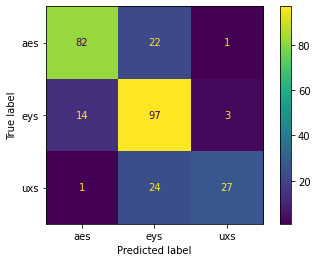

In [37]:
"""
with f1-f4 with diagonal covm
"""
#true_lable,predicted_lable,error_rate = classifier_g(data,data_gender,data_test,4)

true_lable,predicted_lable,error_rate = classifier_g(data_gender,data_test,4, diagonal = True)


cm = confusion_matrix(y_true = true_lable, y_pred =predicted_lable)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= list(data.keys()))

disp.plot()
plt.show()

Error rate was: 25.09 %


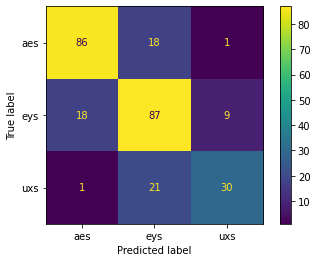

In [38]:
"""
with f1-f4 and b1-b4
"""


true_lable,predicted_lable,error_rate = classifier_g(data_gender,data_test,8, diagonal = True)


cm = confusion_matrix(y_true = true_lable, y_pred =predicted_lable)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= list(data.keys()))

disp.plot()
plt.show()



---



---



# Problem 2

In this problem we use the support vector machine (SVM) to build classifiers. We use the same dataset as in Problem 1. It is up to you to select which features to use.

We use the function `sklearn.svm.SVC` from `scikit-learn` in this problem. First you need to get your data on the format that `SVC` expects, which is a matrix where every row is a feature vector, and a list of integer labels corresponding to each row. We suggest using "ae" = 0, "ey" = 1 and "ux" = 2.

An example on how to use the `SVC` is given in http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC. In short, we do the following (for a linear kernel):
- Instantiate an SVC object: `cls = SVC(kernel='linear')`
- Train the SVM using the feature vector matrix `train_X`, and label vector `train_Y`: `cls.fit(train_X, train_Y)`
- Predict labels on the test set `Test_X` using: `cls.predict(Test_X)`

You can use or adapt the following functions to visualize the SVM decision regions and support vectors in 2D.

###Preprocessing

In [39]:
from sklearn.svm import SVC

In [57]:
"""
Preprocessing
"""
# Load data
train = pd.read_csv("/content/drive/My Drive/ML/Train.csv")
test = pd.read_csv("/content/drive/My Drive/ML/Test.csv")

# Data test

def PreProcess_SVC(data,drop,phoneme):
  """
  Proprocces the date to the format of svc

  data: type= DataFrame
  drop: type = list; commums to drop
  phoneme: type = list, lists of phonems to extract
  

  returns 
  data_pre: type= dataframe; 
  """


  
  phon = []
  phonem_dict = {}
  for n,i in enumerate(phoneme):
    temp = data[data["Phoneme"] == i] #Extract data
    temp = temp.replace(to_replace = i,value = n) #replace phonom with a number
    phonem_dict[i] = n #Stores the old and new value of the phonems
    phon.append(temp)
  
  
  
  data_pre = pd.concat(phon) #combining DataFrames across rows or columns
  label_vector = data_pre["Phoneme"] #need to extract the lable_vector

  data_pre = data_pre.drop(drop,axis=1) #drop the unwanted colums
  data_pre = data_pre.drop( ["SpeakerID","Gender", "Phoneme"],axis=1)
  
 
  
  feature_matrix = data_pre

  return feature_matrix, label_vector, phonem_dict,











###Ploting fuctions

In [46]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


import warnings
warnings.filterwarnings('ignore')



In [86]:
def Plot_SVM_decision_regions(clf,data,labels,ax):
    '''
    This function is for plotting the decision area of SVM
    
    Args:
    - clf: SVM model
    - data: Data with two features
    - labels: Corresponding labels of the data
    '''
    phonemes = np.array(["ae","ey","ux"])
    lab = []
    for i in labels:
      lab.append(phonemes[i])
    
    x_min, x_max = data[:,0].min() - 0.2, data[:,0].max() + 0.2
    y_min, y_max = data[:,1].min() - 0.2, data[:,1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.002),np.arange(y_min, y_max, 0.002))
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(phonemes)
    Z1 = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    #Z = label_encoder.transform(Z)
    Z2 = Z1.reshape(xx.shape)
      #Plotting
      #ax.figure(figsize=(10,6))
    sns.scatterplot(data[:,0],data[:,1],hue=lab,ax=ax)
    ax.contourf(xx, yy, Z2, cmap=plt.cm.ocean, alpha=0.2)
    ax.legend()
    ax.set_title('Decision Area of SVM')
    #plt.show()

def Plot_Support_Vectors(clf,data,ax):
    '''
    This function is for plotting the support vectors of the SVM model
    
    Args:
    - clf: SVM model
    - data: Data with two features
    '''
    
    x_min, x_max = data[:,0].min() - 0.2, data[:,0].max() + 0.2
    y_min, y_max = data[:,1].min() - 0.2, data[:,1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.002),np.arange(y_min, y_max, 0.002))
    Z1 = clf.predict(np.c_[xx.ravel(), yy.ravel()])
      #Z = label_encoder.transform(Z)
    Z2 = Z1.reshape(xx.shape)
      #Plotting
      #ax.figure(figsize=(10,6))
    ax.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], c='k',alpha=0.4,label='support vector')
    ax.contourf(xx, yy, Z2, cmap=plt.cm.ocean, alpha=0.2)
    ax.legend()
    ax.set_title('Support Vectors')
    #plt.show()

##(a) 
Create a linear SVM with different penalty terms $C=\{0.1, 1, 10\}$ and compare with the results in Problem 1.

###Calculating best feature set

In [42]:

from itertools import combinations
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
""" 
Find best featureset

"""

def possibel_feature_combinations(features):
  comb= []
  for i in range(0,len(features)+1):
      temp = combinations(features,i)
      for j in list(temp):
         comb.append(list(j))

     
  return comb

def cal_error_rate(pred,true):
  error =0
  for n,i in enumerate(pred):
    
    if i != true[n]:
      error +=1
  return round(error/len(pred),3)


def best_features(c,kernel,features,train_data,test_data):
  
  best_feat_dict ={"pen":0,"ker":None,"best_feat":None,"error_rate":1000}
  best_feat_dict_train ={"pen":0,"ker":None,"best_feat":None,"error_rate":1000}
  
  for penalty in c:
    print("Penalty", penalty)
    for ker in kernel:
      print("\t Kernel",ker)
      for feat_set in features:
        for feat in feat_set:
          
          train_f_m, train_l_v, phonem_dict = PreProcess_SVC(train,feat,["ae","ey","ux"])
          test_f_m, test_l_v, phonem_dict = PreProcess_SVC(test,feat,["ae","ey","ux"])

          #cls = SVC(kernel=ker, C=penalty)
          cls = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel=ker, C=penalty)) #StandardScaler():Standardize features by removing the mean and scaling to unit variance.
          cls.fit( train_f_m.to_numpy(), train_l_v.to_numpy())


          #test data
          predicted = cls.predict(test_f_m.to_numpy())
        
          error_rate_test = cal_error_rate(predicted,test_l_v.to_numpy())
          
          if error_rate_test < best_feat_dict["error_rate"]:
            best_feat_dict["pen"] = penalty
            best_feat_dict["ker"] = ker
            best_feat_dict["best_feat"] = feat
            
            best_feat_dict["error_rate"] = error_rate_test
            print("\t \t new",best_feat_dict)


          #training
          predicted_train = cls.predict(train_f_m.to_numpy())

          error_rate_train = cal_error_rate(pred = predicted_train,true = train_l_v.to_numpy())
          
          if error_rate_train < best_feat_dict_train["error_rate"]:
            best_feat_dict_train["pen"] = penalty
            best_feat_dict_train["ker"] = ker
            best_feat_dict_train["best_feat"] = feat
          
            best_feat_dict_train["error_rate"] = error_rate_train
            




  return best_feat_dict , best_feat_dict_train

feat = ["F1","F2","F3","F4","B1","B2","B3","B4"]
c =[0.1,1,10]
kernel = ["linear", 'rbf', 'poly', 'sigmoid']

all_features = possibel_feature_combinations(feat)


temp, temp_1 = best_features(c=c,kernel=kernel,features=all_features,train_data = train,test_data=test)
print(temp)
print(temp_1)

Penalty 0.1
	 Kernel linear
	 	 new {'pen': 0.1, 'ker': 'linear', 'best_feat': 'F1', 'error_rate': 0.432}
	 	 new {'pen': 0.1, 'ker': 'linear', 'best_feat': 'F2', 'error_rate': 0.273}
	 	 new {'pen': 0.1, 'ker': 'linear', 'best_feat': 'F3', 'error_rate': 0.269}
	 	 new {'pen': 0.1, 'ker': 'linear', 'best_feat': 'B3', 'error_rate': 0.262}
	 Kernel rbf
	 Kernel poly
	 Kernel sigmoid
Penalty 1
	 Kernel linear
	 	 new {'pen': 1, 'ker': 'linear', 'best_feat': 'B2', 'error_rate': 0.258}
	 Kernel rbf
	 Kernel poly
	 Kernel sigmoid
Penalty 10
	 Kernel linear
	 	 new {'pen': 10, 'ker': 'linear', 'best_feat': 'B2', 'error_rate': 0.255}
	 	 new {'pen': 10, 'ker': 'linear', 'best_feat': 'B3', 'error_rate': 0.251}
	 Kernel rbf
	 Kernel poly
	 Kernel sigmoid
{'pen': 10, 'ker': 'linear', 'best_feat': 'B3', 'error_rate': 0.251}
{'pen': 10, 'ker': 'rbf', 'best_feat': 'F2', 'error_rate': 0.074}


**Comments**



> As we can se abowe the result of testing all the diffrent features withe the diffrent kernels gives diffrent results. 



###Confusion matrix of different kernel values for both training and test data 


 Results for C=0.1


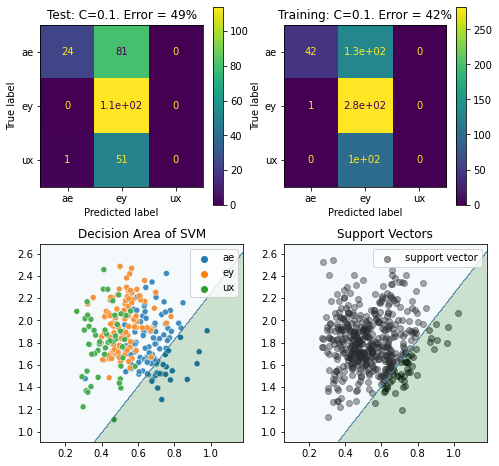


 Results for C=1


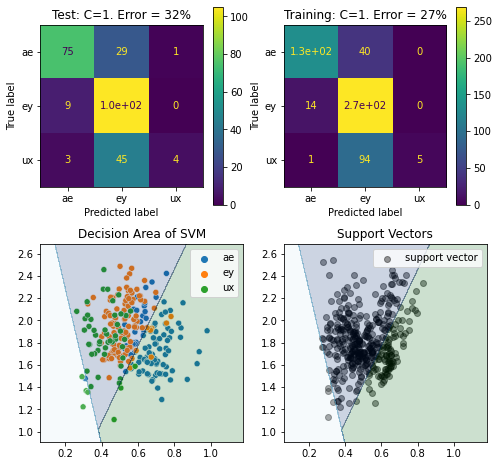


 Results for C=10


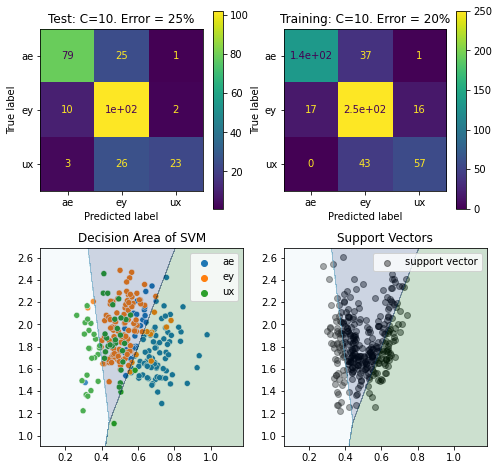

In [88]:
train_f_m, train_l_v, phonem_dict = PreProcess_SVC(train,["F3","F4","B1","B2","B3","B4"],["ae","ey","ux"])
test_f_m, test_l_v, phonem_dict = PreProcess_SVC(test,["F3","F4","B1","B2","B3","B4"],["ae","ey","ux"])




from sklearn.svm import SVC
c= [0.1,1,10]
for penalty in c:
  print(f"\n Results for C={penalty}")
  fig, axs = plt.subplots(2, 2,figsize=(8,8))

  cls = SVC(kernel="linear",C=penalty)
  #cls = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel="linear", C=penalty))
  cls.fit( train_f_m.to_numpy(), train_l_v.to_numpy())

  #Test data
  predicted = cls.predict(test_f_m.to_numpy())
  error_rate = cal_error_rate(predicted,test_l_v.to_numpy())
  
  cm_test = confusion_matrix(y_true = test_l_v.to_numpy(), y_pred =predicted)
  disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels= ["ae","ey","ux"])
  disp_test.plot(ax=axs[0,0])
  axs[0,0].set_title("Test: C={}. Error = {}%".format(penalty,round(error_rate*100),2))

  Plot_SVM_decision_regions(cls,test_f_m.to_numpy(),test_l_v.to_numpy(),ax =axs[1,0])
  Plot_Support_Vectors(cls,test_f_m.to_numpy(),ax=axs[1,1])



  #train data

  predicted = cls.predict(train_f_m.to_numpy())
  error_rate = cal_error_rate(predicted,train_l_v.to_numpy())
 
  cm_train = confusion_matrix(y_true = train_l_v.to_numpy(), y_pred =predicted)
  disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels= ["ae","ey","ux"])
  disp_train.plot(ax=axs[0,1])
  axs[0,1].set_title("Training: C={}. Error = {}%".format(penalty,round(error_rate*100),3))



  plt.show()





##(b) 
Try different kernels ('rbf', 'poly', 'sigmoid') and compare the results. Choose one of the kernels and use different penalty terms $C$. What happens with the performance on the training set when you increase $C$? What happens with the performance on the test set?

In [44]:
train_f_m, train_l_v, phonem_dict = PreProcess_SVC(train,["B3"],["ae","ey","ux"])
test_f_m, test_l_v, phonem_dict = PreProcess_SVC(test,["B3"],["ae","ey","ux"])



pref = {}
from sklearn.svm import SVC
c= np.arange(0.1,20,0.1)
cs = [[],[],[],[]]
test_c =  [[],[],[],[]]
train_c =  [[],[],[],[]]
for n,k in enumerate(kernel):
  
  for penalty in c:
    

    #cls = SVC(kernel="linear",C=penalty)
    cls = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel=k, C=penalty))
    cls.fit( train_f_m.to_numpy(), train_l_v.to_numpy())

    #Test data
    predicted = cls.predict(test_f_m.to_numpy())
    error_rate_test = cal_error_rate(predicted,test_l_v.to_numpy())
    

    #train data

    predicted = cls.predict(train_f_m.to_numpy())
    error_rate_train = cal_error_rate(predicted,train_l_v.to_numpy())
    
    
    cs[n].append(penalty)
    
    test_c[n].append(error_rate_test)
    train_c[n].append(error_rate_train)
  pref[k] =temp
  
   

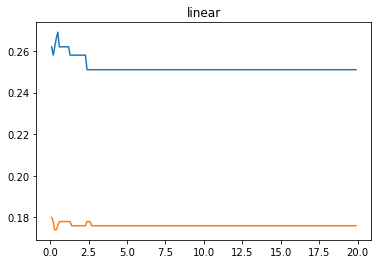

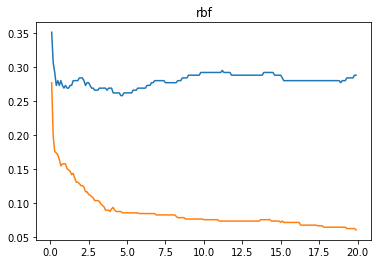

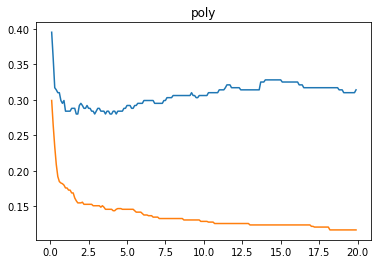

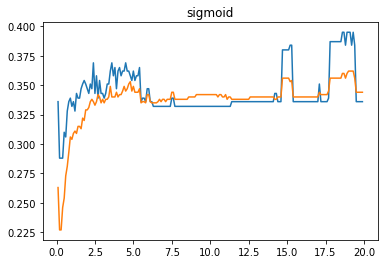

In [45]:

for i in range(len(cs)):
  plt.title(kernel[i])
  plt.plot(cs[i],test_c[i],label ="Test")
  plt.plot(cs[i],train_c[i],label ="Train")
  plt.show()